In [1]:
library(qs)
library(dplyr)
library(lme4)
setwd("/cluster/home/liuhengxin/P1_brain_nanopore/downstream_analysis/")

qs 0.26.3


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix



In [47]:
fsraw.cor = qread("data/reads_full_anotation/main_data_read_total_annotation_delete_multiread_24_09_04.qs")
fsraw.cor = fsraw.cor[fsraw.cor$layer %in% paste0("l",1:6),]

In [3]:
cellan = read.csv("../ref/cell_type_type20230220-macaque1-contour2_v1.csv")
cellan = unique(cellan[,c("subclass","class")])
transtf.lobe = transtls_inter$lobe
transtf.lobe$areatr = transtf.lobe$lobe
head(transtf.lobe)

lobe,subclass,gene_id,transcript_id,count,genecount,relative,meanrelative,areatr
<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<chr>
auditory,ASC,AACS,NM_001284010.1,1,1,1.0000000,0.8572222,auditory
auditory,ASC,AADAT,XM_005556302.2,3,4,0.7500000,0.4362745,auditory
auditory,ASC,AADAT,XM_005556303.2,1,4,0.2500000,0.7328431,auditory
auditory,ASC,AAK1,XM_005575681.2,8,8,1.0000000,1.0000000,auditory
auditory,ASC,AAMDC,AAMDC-WeiLab-1,4,11,0.3636364,0.3997602,auditory
auditory,ASC,AAMDC,XM_005579175.2,7,11,0.6363636,0.5730936,auditory


In [10]:
transtf = transtls_inter$inner
transtf = transtf %>% group_by(gene_id,transcript_id) %>% mutate(tcount = sum(count))
transtf = transtf[transtf$tcount > 1000,]
transtf = transtf %>% group_by(gene_id) %>% filter(length(unique(transcript_id))>1)
#transtf = transtf[paste0(transtf$subclass,transtf$layer) %in% paste0(substf$subclass,substf$layer),]
transtf.glu = transtf[transtf$subclass %in% cellan[cellan$class == "GLU",]$subclass,]
transtf.other = transtf[!(transtf$subclass %in% cellan[cellan$class == "GLU",]$subclass),]
transtf.glu$layer = substf[match(transtf.glu$subclass,substf$subclass),]$layer
transtf.glu = transtf.glu %>% group_by(gene_id,transcript_id,subclass,lobe,layer) %>% 
summarise(count = sum(count),genecount = sum(genecount),tcount = tcount[1],
          relative = sum(count)/sum(genecount))
transtf = rbind(transtf.glu,transtf.other[,colnames(transtf.glu)])
transtf = transtf %>% group_by(gene_id,transcript_id,subclass) %>% mutate(cellm = sum(count)/sum(genecount))
transtf = transtf %>% group_by(gene_id,transcript_id,lobe) %>% mutate(lobem = sum(count)/sum(genecount))
transtf = transtf %>% group_by(gene_id,transcript_id,layer) %>% mutate(layerm = sum(count)/sum(genecount))
transtf = transtf[transtf$genecount > 10,]
transtf = transtf %>% group_by(transcript_id) %>% filter(mean(count) > 10)
transtf = transtf %>% group_by(transcript_id) %>% 
       filter(length(unique(lobe)) > 5 & length(unique(subclass)) > 5)
# transtf = transtf %>% group_by(layer,subclass,transcript_id) %>% 
#        filter(length(unique(lobe)) > 2)
transt.lobei = transtf


In [90]:
#transtf = fsraw.cor %>% group_by(gene_id,transcript_id) %>% mutate(tcount = sum(count))
#transtf = transtf[transtf$tcount > 1000,]
transt = fsraw.cor %>% group_by(gene_id,transcript_id,subclass,lobe,region) %>% 
          summarise(count = length(readid)) %>% group_by(gene_id,subclass,lobe,region) %>% 
          mutate(genecount = sum(count),relative = count/genecount)
transt = transt %>% group_by(lobe) %>% mutate(tcount = sum(count))
transtf = transt %>% group_by(gene_id) %>% filter(length(unique(transcript_id)) > 1 )
#transtf = transtf[transtf$count > 5,]
#transtf = transtf[paste0(transtf$subclass,transtf$layer) %in% paste0(substf$subclass,substf$layer),]
transtf = transtf %>% group_by(gene_id,transcript_id,subclass) %>% mutate(cellm = sum(count)/sum(genecount))
transtf = transtf %>% group_by(gene_id,transcript_id,lobe) %>% mutate(lobem = sum(count)/sum(genecount))
transtf = transtf %>% group_by(gene_id,transcript_id,region) %>% mutate(regionm = sum(count)/sum(genecount))
transtf = transtf[transtf$genecount > 10,]
transtf = transtf %>% group_by(transcript_id,subclass) %>% filter(length(unique(lobe)) == 6)
transtf = transtf %>% group_by(transcript_id) %>% filter(length(unique(subclass)) > 6)
transt.lobei = transtf[transtf$subclass != "",]
length(unique(transtf$gene_id))

`summarise()` has grouped output by 'gene_id', 'transcript_id', 'subclass',
'lobe'. You can override using the `.groups` argument.


[1] 480

In [78]:
transt.hub = transt.lobei[transt.lobei$gene_id == "RTN1",]
#ggplot(transt.hub,aes(x = lobe,y = relative,fill = transcript_id)) + geom_boxplot()
#ggplot(transt.hub,aes(x = subclass,y = relative,fill = transcript_id)) + geom_boxplot()
transt.hub %>% group_by(transcript_id,lobe) %>% summarise(length(unique(subclass)))

`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


transcript_id,lobe,length(unique(subclass))
<chr>,<chr>,<int>
XM_005561388.2,auditory,18
XM_005561388.2,cingulate,18
XM_005561388.2,occipital,18
XM_005561388.2,parietal,18
XM_005561388.2,somatosensory,18
XM_005561388.2,temporal,18
XM_005561389.2,auditory,18
XM_005561389.2,cingulate,18
XM_005561389.2,occipital,18


In [96]:
model_with_region = glmer(relative ~  cellm + regionm + (1|count),
                            family = binomial(),
                            data = transt.lobei[transt.lobei$gene_id == "RTN1",],
                            na.action = na.exclude)
summary(model_with_region)

Warning message in eval(family$initialize, rho):
“non-integer #successes in a binomial glm!”
boundary (singular) fit: see help('isSingular')



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: relative ~ cellm + regionm + (1 | count)
   Data: transt.lobei[transt.lobei$gene_id == "RTN1", ]

     AIC      BIC   logLik deviance df.resid 
    90.8    109.7    -41.4     82.8      830 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.2896 -2.5394  0.1723  3.9146 11.0963 

Random effects:
 Groups Name        Variance Std.Dev.
 count  (Intercept) 0        0       
Number of obs: 834, groups:  count, 166

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -10.935      1.131  -9.669   <2e-16 ***
cellm          2.119      8.300   0.255   0.7985    
regionm       18.898      8.111   2.330   0.0198 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
        (Intr) cellm 
cellm   -0.192       
regionm -0.019 -0.975
optimizer (Nelder_Mead) convergence code: 0 (OK)
bo

In [30]:
#transt.lobei[transt.lobei$transcript_id == "DDRGK1-WeiLab-1",]
#transt.lobei = transtf
model_with_region = tryCatch(glmer(relative ~  cellm + lobem  + (1|transcript_id),
                            family = binomial(),
                            data = transt.lobei[transt.lobei$gene_id == "DDRGK1",],
                            na.action = na.exclude), 
                   error = function(e) NA)
summary(model_with_region)

model_with_region = tryCatch(glmer(relative ~  cellm + lobem  + (1|transcript_id),
                            family = binomial(),
                            data = transt.lobei[transt.lobei$gene_id == "RTN1",],
                            na.action = na.exclude), 
                   error = function(e) NA)
summary(model_with_region)

Warning message in eval(family$initialize, rho):
“non-integer #successes in a binomial glm!”
boundary (singular) fit: see help('isSingular')



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: relative ~ cellm + lobem + (1 | transcript_id)
   Data: transt.lobei[transt.lobei$gene_id == "DDRGK1", ]

     AIC      BIC   logLik deviance df.resid 
   183.7    196.7    -87.8    175.7      188 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2106 -0.6003 -0.0157  0.5276  3.6214 

Random effects:
 Groups        Name        Variance  Std.Dev. 
 transcript_id (Intercept) 1.864e-10 1.365e-05
Number of obs: 192, groups:  transcript_id, 2

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -19.052      3.624  -5.257 1.46e-07 ***
cellm         18.988      2.815   6.744 1.54e-11 ***
lobem         18.437      5.960   3.093  0.00198 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
      (Intr) cellm 
cellm -0.568       
lobem -0.920  0.205
optimizer (Nelder_Mead) c

Warning message in eval(family$initialize, rho):
“non-integer #successes in a binomial glm!”
boundary (singular) fit: see help('isSingular')



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: relative ~ cellm + lobem + (1 | transcript_id)
   Data: transt.lobei[transt.lobei$gene_id == "RTN1", ]

     AIC      BIC   logLik deviance df.resid 
    41.5     55.2    -16.8     33.5      219 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-4.318 -2.567 -1.547  2.469  3.852 

Random effects:
 Groups        Name        Variance Std.Dev.
 transcript_id (Intercept) 0        0       
Number of obs: 223, groups:  transcript_id, 2

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -10.789      1.589  -6.790 1.12e-11 ***
cellm          8.015     11.273   0.711    0.477    
lobem         13.491     11.806   1.143    0.253    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
      (Intr) cellm 
cellm  0.054       
lobem -0.286 -0.968
optimizer (Nelder_Mead) convergence code:

In [97]:

# transtf = transtls_inter$inner %>% group_by(subclass,gene_id) %>% 
#       filter(length(unique(transcript_id))>1)
# transtf = transtf[transtf$count > 10,]
# transtf = transtf %>% group_by(subclass,transcript_id) %>% 
#        filter(length(unique(lobe)) > 3)
# #transtf = transtf[paste0(transtf$subclass,transtf$layer) %in% paste0(substf$subclass,substf$layer),]
# transtf = transtf %>% group_by(gene_id,transcript_id,subclass) %>% mutate(cellm = sum(count)/sum(genecount))
# transtf = transtf %>% group_by(gene_id,transcript_id,lobe) %>% mutate(lobem = sum(count)/sum(genecount))
# transtf = transtf %>% group_by(gene_id,transcript_id,layer) %>% mutate(layerm = sum(count)/sum(genecount))
# transt.lobei = transtf
# data 中包含以下列：
# gene_expression: 基因表达水平
# cell_type: 细胞类型（a, b, c）
# region: 空间区域（A, B, C）
# gene_id: 基因标识符

# 读取数据
# 模型拟合，包括区域效应

modelcoef2 = NULL
length(unique(transt.lobei$gene_id))
for(i in unique(transt.lobei$gene_id)){
    model_with_region = tryCatch(glmer(relative ~  cellm + regionm + (1|count),
                            family = binomial(),
                            data = transt.lobei[transt.lobei$gene_id == i,],
                            na.action = na.exclude), 
                   error = function(e) NA)

    if(!is.na(model_with_region)){
        modelsm = tryCatch(summary(model_with_region),error = function(e) NA)
        if(length(modelsm) == 1) next;
        modelsmdf = as.data.frame(modelsm$coefficients)
        modelsmdf$gene_id = i
        # gi = transt.lobei[transt.lobei$transcript_id == i,]$gene_id[1]
        # modelsmdf$gene_id = gi
        modelsmdf$areatr = rownames(modelsmdf)
        modelcoef2 = rbind(modelcoef2,modelsmdf)
    }    
    
   # print(summary(model_with_region))
}
#transt.lobei

[1] 480

Warning message in eval(family$initialize, rho):
“non-integer #successes in a binomial glm!”
boundary (singular) fit: see help('isSingular')

Warning message in is.na(model_with_region):
“is.na() applied to non-(list or vector) of type 'S4'”
Warning message in vcov.merMod(object, use.hessian = use.hessian):
“variance-covariance matrix computed from finite-difference Hessian is
not positive definite or contains NA values: falling back to var-cov estimated from RX”
Warning message in vcov.merMod(object, correlation = correlation, sigm = sig):
“variance-covariance matrix computed from finite-difference Hessian is
not positive definite or contains NA values: falling back to var-cov estimated from RX”
Warning message in eval(family$initialize, rho):
“non-integer #successes in a binomial glm!”
boundary (singular) fit: see help('isSingular')

Warning message in is.na(model_with_region):
“is.na() applied to non-(list or vector) of type 'S4'”
Warning message in vcov.merMod(object, use.hessian =

In [98]:
modelcoef2[modelcoef2$gene_id == "RTN1",]
colnames(modelcoef2)[4] = "pvalue"
#hubgene = unique(modelcoef2[modelcoef2$pvalue < 0.05 & (modelcoef2$areatr %in% c("lobem","layerm")),]$gene_id)
#hubgene[order(hubgene)]
length(unique(modelcoef2$gene_id))
#length(unique(modelcoef2[modelcoef2$pvalue < 0.05 & (modelcoef2$areatr %in% c("layerm")),]$gene_id))
#length(unique(modelcoef2[modelcoef2$pvalue < 0.05 & (modelcoef2$areatr %in% c("lobem")),]$gene_id))
length(unique(modelcoef2[modelcoef2$pvalue < 0.05 & (modelcoef2$areatr %in% c("lobem")),]$gene_id))
length(unique(modelcoef2[modelcoef2$pvalue < 0.05 & (modelcoef2$areatr %in% c("regionm")),]$gene_id))
length(unique(modelcoef2[modelcoef2$pvalue < 0.05 & (modelcoef2$areatr %in% c("cellm")),]$gene_id))
#hubb = unique(modelcoef2[modelcoef2$pvalue < 0.05 & (modelcoef2$areatr %in% c("lobem")),]$gene_id)
hubb = unique(modelcoef2[modelcoef2$pvalue < 0.05 & (modelcoef2$areatr %in% c("regionm")),]$gene_id)
hubc = unique(modelcoef2[modelcoef2$pvalue < 0.05 & (modelcoef2$areatr %in% c("cellm")),]$gene_id)
#hubl = unique(modelcoef2[modelcoef2$pvalue < 0.05 & (modelcoef2$areatr %in% c("layerm")),]$gene_id)
length(intersect(hubc,hubb))
qsave(modelcoef2,"data/dtu_analysis/region_subclass_isoform_model_tri_onlyregion_24_12_20.qs")

,Estimate,Std. Error,z value,Pr(>|z|),gene_id,areatr
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
(Intercept)365,-10.934623,1.130890,-9.6690381,4.081967e-22,RTN1,(Intercept)
cellm365,2.119326,8.299861,0.2553447,7.984568e-01,RTN1,cellm
regionm365,18.897765,8.111168,2.3298451,1.981434e-02,RTN1,regionm


[1] 462

[1] 0

[1] 93

[1] 83

[1] 47

[1] "ADGRB3"       "ATP6V1C1"     "BCLAF1"       "CCNH"         "DLG2"        
 [6] "DNAJB4"       "FHL2"         "GRHPR"        "HERC2"        "KCNIP4"      
[11] "KLHDC9"       "KMT2C"        "LDB2"         "LOC102140686" "MAPKAP1"     
[16] "MAT2B"        "NDUFAF5"      "NDUFS1"       "PDE4D"        "PHACTR3"     
[21] "PHF20L1"      "PID1"         "PKM"          "PPP2R2B"      "PPP3R1"      
[26] "RBFOX2"       "RGS7"         "RIMS1"        "RNMT"         "RUFY2"       
[31] "SETBP1"       "SH3GL3"       "SLC4A10"      "SPTAN1"       "SRP54"       
[36] "TENM2"        "THYN1"        "TPM3"         "UBQLN1"       "USP9X"       
[41] "VAMP4"        "WAPL"         "WHSC1L1"      "ZMYM2"        "ZNF385B"

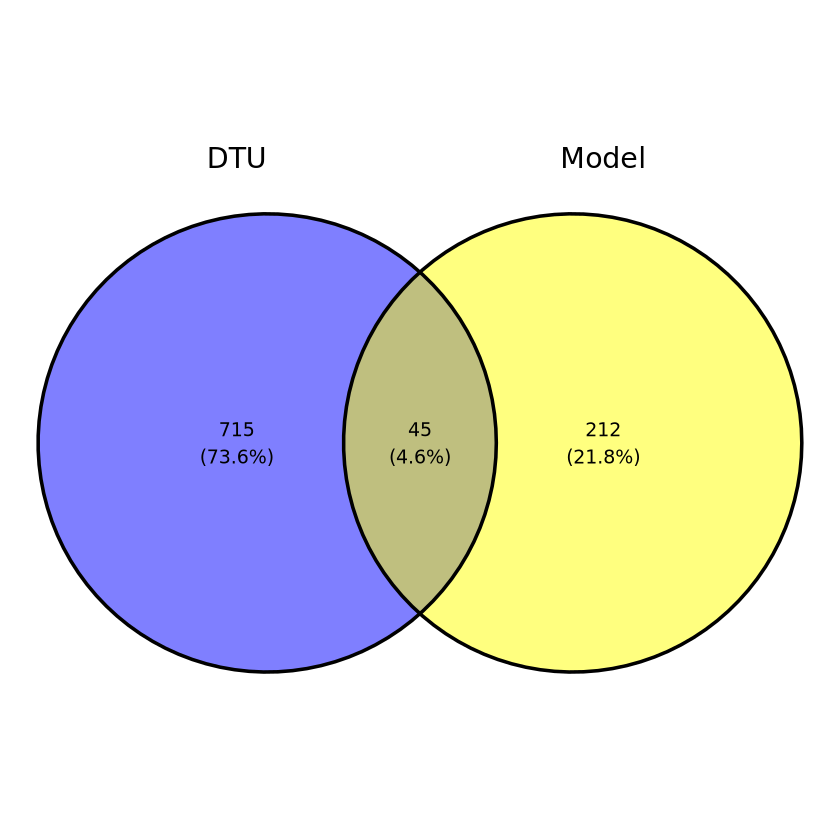

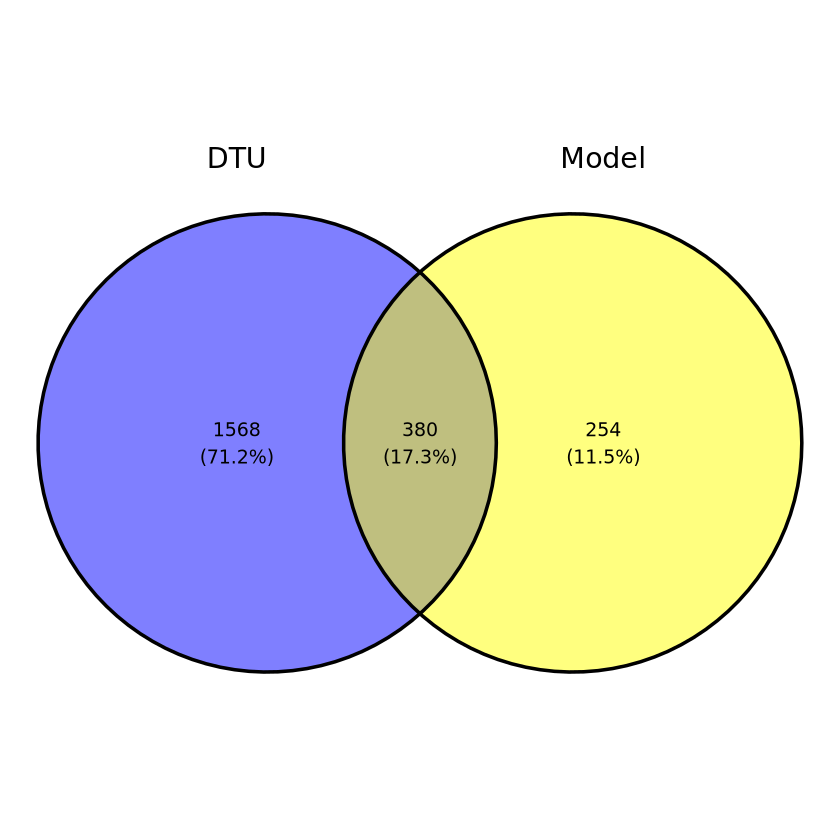

In [38]:
isosigls = qread(file = "data/dtu_analysis/dtu_isoform_ls_fsraw_cor_24_09_04.qs")
isosigi = isosigls$lobe
hubbr = isosigi[isosigi$sig != "N",]$gene_id
intersect(hubbr,hubb)
library(ggvenn)
ggvenn(list("DTU" = hubbr,"Model" = hubb))

isosigi = isosigls$subclass
hubcr = isosigi[isosigi$sig != "N",]$gene_id
ggvenn(list("DTU" = hubcr,"Model" = hubc))

In [46]:
isosigi = isosigls$lobe
isosigi.hub = isosigi[(isosigi$gene_id %in% hubb),]
isosigi.hub = isosigi.hub[order(-isosigi.hub$genecount),]
unique(isosigi.hub$gene_id)

[1] "RPLP2"           "RPS21"           "SNRPN"           "YWHAH"          
  [5] "RPS10"           "RPSA"            "FKBP2"           "CAMK2B"         
  [9] "DDRGK1"          "S100B"           "SPTAN1"          "TCEB1"          
 [13] "SH3BGRL3"        "ARF5"            "NDUFS7"          "TPM3"           
 [17] "SLC25A3"         "MEA1"            "LOC107131073"    "HNRNPA2B1"      
 [21] "CABP1"           "TCEA2"           "LOC107126439"    "TTYH1"          
 [25] "VTI1B"           "EPHB6"           "HNRNPDL"         "THRA"           
 [29] "RUNDC3A"         "BOLA3"           "PSIP1"           "ANKS1B"         
 [33] "RPP21"           "CPLX2"           "GUK1"            "AURKAIP1"       
 [37] "MOBP"            "TSTD1"           "POLR3H"          "PSMA4"          
 [41] "ENHO"            "NNAT"            "CCDC136"         "SRSF5"          
 [45] "ZEB2"            "BCL11A"          "FAM213A"         "PTGES3"         
 [49] "MATR3"           "KCNIP4"          "RBFOX3"          "PTPMT1"         
 [53] "VDAC3"           "MORF4L2"         "PCMT1"           "BUD31"          
 [57] "SCOC"            "HNRNPA1"         "CNTNAP2"         "CAPRIN1"        
 [61] "PQBP1"           "NCAM1"           "UBQLN1"          "OCIAD1"         
 [65] "VAPA"            "RBFOX2"          "RPS24"           "TM2D3"          
 [69] "SMIM19"          "ERC2"            "R3HDM2"          "SLC44A1"        
 [73] "CCDC53"          "HNRNPA3"         "TNIK"            "DLG2"           
 [77] "SRSF7"           "RASL10A"         "PPP2R2B"         "CMC2"           
 [81] "USP9X"           "EMC7"            "PPM1B"           "SRSF3"          
 [85] "BCAN"            "YDJC"            "RAB24"           "GET4"           
 [89] "KCNA6"           "PDRG1"           "FAM58A"          "NSFL1C"         
 [93] "AP1S2"           "RAB18"           "COPS5"           "TPM1"           
 [97] "LOC102141085"    "NAP1L3"          "ATP6V1C1"        "PSMC4"          
[101] "RAPGEF4"         "BRD8"            "SUGP2"           "PTRH2"          
[105] "DTNA"            "CCDC88A"         "STOML2"          "LOC102130589"   
[109] "SLC4A10"         "RIMS1"           "TMEM219"         "LOC107126716"   
[113] "LOC102137822"    "CHURC1"          "SRRM2"           "PLCL2"          
[117] "PHF14"           "NUDT22"          "GPAA1"           "CADM2"          
[121] "ZFAND2B"         "LOC101925240"    "TENM2"           "LAMP2"          
[125] "SDF4"            "CCNH"            "SIK3"            "MTX2"           
[129] "PKM"             "SCP2"            "BRD2"            "SURF2"          
[133] "CREM"            "ZEB1"            "BambuGene59766"  "BCLAF1"         
[137] "SF1"             "MED4"            "SH3GL3"          "RGS7"           
[141] "PSMF1"           "KCNMA1"          "SNRNP35"         "LRRC7"          
[145] "PHACTR3"         "NME4"            "RNASET2"         "BEND5"          
[149] "TOLLIP"          "PPP3R1"          "C1H1orf43"       "PSME3"          
[153] "UCHL3"           "PSMG1"           "DLG1"            "RNF8"           
[157] "DDX54"           "NCOR1"           "LRRC4C"          "SPEG"           
[161] "NDUFS1"          "CSNK1A1"         "JAKMIP1"         "ZCRB1"          
[165] "TSC2"            "FADS3"           "PHF20L1"         "PPP1R3E"        
[169] "FHL2"            "ADGRB3"          "NTM"             "RNPC3"          
[173] "LDB2"            "RGS12"           "CCNDBP1"         "BTF3L4"         
[177] "ATXN2"           "WHSC1L1"         "HNRNPH1"         "MAPKAP1"        
[181] "KCNN1"           "HERC2"           "DDX46"           "KMT2C"          
[185] "TNRC6B"          "FLAD1"           "PSPC1"           "PID1"           
[189] "FRMD4A"          "MAT2B"           "CHCHD7"          "SUSD4"          
[193] "LOC102133400"    "THYN1"           "APOPT1"          "YIF1A"          
[197] "KCNC2"           "RPL7A"           "SLC8A1"          "ZFAND2A"        
[201] "NUTF2"           "RUNX1T1"         "GRIA4"           "SGSM3"          
[205] "RNMT"            

In [96]:
isosigib = isosigls$lobe
isosigib = isosigib[isosigib$gene_id %in% hubb & !(isosigib$gene_id %in% hubc),]
isosigic = isosigls$subclass
isosigic = isosigic[isosigic$gene_id %in% hubc,]
isosigib = isosigib %>% group_by(transcript_id) %>% summarise(dr = max(abs(dr)))
isosigic = isosigic %>% group_by(transcript_id) %>% summarise(dr = max(abs(dr)))
summary(abs(isosigib$dr))
summary(abs(isosigic$dr))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00625 0.02289 0.04052 0.04638 0.05692 0.20235 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02910 0.08123 0.11816 0.14280 0.17721 0.40642 

In [9]:
modelcoef2$group = modelcoef2$areatr
modelcoef2[substr(modelcoef2$areatr,1,4) == "lobe",]$group = "lobe"
modelcoef2[substr(modelcoef2$areatr,1,5) == "layer",]$group = "layer"
modelcoef2[substr(modelcoef2$areatr,1,4) == "cell",]$group = "subclass"
modelcoef2[modelcoef2$group == "layer",]$areatr = substr(modelcoef2[modelcoef2$group == "layer",]$areatr,6,
                                                         nchar(modelcoef2[modelcoef2$group == "layer",]$areatr))
modelcoef2[modelcoef2$group == "lobe",]$areatr = substr(modelcoef2[modelcoef2$group == "lobe",]$areatr,5,
                                                        nchar(modelcoef2[modelcoef2$group == "lobe",]$areatr))
#modelcoef2[modelcoef2$group == "subclass",]$areatr = substr(modelcoef2[modelcoef2$group == "subclass",]$areatr,9,nchar(modelcoef2[modelcoef2$group == "subclass",]$areatr))
head(modelcoef2)

,Estimate,Std. Error,z value,Pr(>|z|),gene_id,areatr,group
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
(Intercept),-10.6951899,1.4192298,-7.5359111,4.849368e-14,APOE,(Intercept),(Intercept)
cellm,22.0455826,2.0400011,10.8066524,3.201405e-27,APOE,,subclass
lobecingulate,-0.1096051,0.7913018,-0.1385124,8.898355e-01,APOE,cingulate,lobe
lobeoccipital,-0.2331339,0.8001620,-0.2913584,7.707772e-01,APOE,occipital,lobe
lobeparietal,-0.3007952,0.7711558,-0.3900576,6.964939e-01,APOE,parietal,lobe
lobesomatosensory,-0.1653106,0.7977037,-0.2072331,8.358278e-01,APOE,somatosensory,lobe


In [13]:
unique(modelcoef2[modelcoef2$pvalue < 0.05 & (modelcoef2$group %in% c("lobe")),]$gene_id)
unique(modelcoef2[modelcoef2$pvalue < 0.05 & (modelcoef2$group %in% c("layer")),]$gene_id)
length(unique(modelcoef2[modelcoef2$pvalue < 0.05 & (modelcoef2$group %in% c("layer")),]$gene_id))
length(unique(modelcoef2[modelcoef2$pvalue < 0.05 & (modelcoef2$group %in% c("lobe")),]$gene_id))
length(unique(modelcoef2[modelcoef2$pvalue < 0.05 & (modelcoef2$group %in% c("subclass")),]$gene_id))

[1] "DDRGK1"       "HNRNPA2B1"    "LOC102122855" "EPHB6"

[1] "CFL1"  "GAP43" "YWHAE" "CAMLG" "HAGH"

[1] 5

[1] 4

[1] 120

In [98]:
#try lobe
library(dplyr)

ModelBuilt = function(transtls_inter){
    transtf = transtls_inter %>% group_by(subclass,gene_id) %>% 
      filter(length(unique(transcript_id))>1)

    transtf = transtf[transtf$count > 10,]
    transtf = transtf %>% group_by(subclass,transcript_id) %>% 
       filter(length(unique(areatr)) > 3)
    library(lme4)
    transt.lobei = transtf
    modelcoef = NULL
    for(i in unique(transt.lobei$gene_id)){
        model_with_region = tryCatch(glmer(relative ~  meanrelative + areatr + (1|count) + (1|transcript_id),
                            family = binomial(),
                            data = transt.lobei[transt.lobei$gene_id == i,],
                            na.action = na.exclude), 
                   error = function(e) NA)
        if(!is.na(model_with_region)){
            modelsm = tryCatch(summary(model_with_region),error = function(e) NA)
            if(length(modelsm) == 1) next;
            modelsmdf = as.data.frame(modelsm$coefficients)
            modelsmdf$gene_id = i
       
            modelsmdf$areatr = rownames(modelsmdf)
            modelcoef = rbind(modelcoef,modelsmdf)
        }    
    
   # print(summary(model_with_region))
    }
    modelcoef$groupt = substr(modelcoef$areatr,1,6)
    modelcoef$group = modelcoef$groupt
    modelcoef[modelcoef$groupt == "areatr",]$group = "areatr"
    return(modelcoef)
}
transtf.lobe = transtls_inter$lobe
transtf.lobe$areatr = transtf.lobe$lobe
modeldf.lobe = ModelBuilt(transtf.lobe)
colnames(modeldf.lobe)[4] = "pvalue"
#modelcoef[modelcoef$pvalue < 0.05,] %>% group_by(group) %>% summarise(max(abs(Estimate)))
modeldf.lobe.hub = modeldf.lobe[modeldf.lobe$pvalue < 0.05 & modeldf.lobe$group %in% c("areatr"),]
length(unique(modeldf.lobe.hub$gene_id))
unique(modeldf.lobe.hub$gene_id)

Warning message in eval(family$initialize, rho):
“non-integer #successes in a binomial glm!”
Warning message in eval(family$initialize, rho):
“non-integer #successes in a binomial glm!”
boundary (singular) fit: see help('isSingular')

Warning message in is.na(model_with_region):
“is.na() applied to non-(list or vector) of type 'S4'”
Warning message in vcov.merMod(object, use.hessian = use.hessian):
“variance-covariance matrix computed from finite-difference Hessian is
not positive definite or contains NA values: falling back to var-cov estimated from RX”
Warning message in vcov.merMod(object, correlation = correlation, sigm = sig):
“variance-covariance matrix computed from finite-difference Hessian is
not positive definite or contains NA values: falling back to var-cov estimated from RX”
Warning message in eval(family$initialize, rho):
“non-integer #successes in a binomial glm!”
boundary (singular) fit: see help('isSingular')

Warning message in is.na(model_with_region):
“is.na() appli

[1] 250

[1] "ADNP"            "AIFM3"           "AKAP9"           "APOE"           
  [5] "ARF5"            "ARGLU1"          "ARPP19"          "ATP2A2"         
  [9] "ATP6V0B"         "BCAN"            "CA11"            "CAMK2B"         
 [13] "CAMLG"           "CAPRIN1"         "CCDC88A"         "CCK"            
 [17] "CCNI"            "CFL1"            "CNBP"            "DCXR"           
 [21] "DDRGK1"          "FAM162A"         "FEZ1"            "FKBP2"          
 [25] "HAGH"            "HCFC1R1"         "HNRNPA2B1"       "HNRNPDL"        
 [29] "HOPX"            "IDH3B"           "ITGB1BP1"        "LAMP2"          
 [33] "LOC101925770"    "LOC102122855"    "LOC102133057"    "LOC102141554"   
 [37] "LOC107131073"    "MEA1"            "MORF4L1"         "MPC1"           
 [41] "MYL6"            "MYL6B"           "NCAM1"           "NDUFS4"         
 [45] "NDUFS7"          "NGFRAP1"         "NPDC1"           "NTRK2"          
 [49] "NUDC"            "OSBPL1A"         "PAK1"            "PARK7"          
 [53] "PIN1"            "PNISR"           "PPM1B"           "PSMC5"          
 [57] "PSMD4"           "PTN"             "QDPR"            "RNPC3"          
 [61] "RPL15"           "RPLP2"           "RPS10"           "RPS21"          
 [65] "RPSA"            "RTN1"            "RWDD1"           "SLC25A3"        
 [69] "SLC44A1"         "SNF8"            "SNRPN"           "SNX3"           
 [73] "SPTAN1"          "SRSF5"           "SYT1"            "THRA"           
 [77] "TMEM205"         "TNIK"            "TRAPPC1"         "TRIM9"          
 [81] "TSC22D4"         "TUBB2B"          "VDAC2"           "YWHAE"          
 [85] "YWHAH"           "ZNF428"          "ZNF706"          "ACTR2"          
 [89] "ANAPC15"         "ANKS1B"          "APOD"            "ARPC2"          
 [93] "ATP2B1"          "AURKAIP1"        "BNIP3L"          "BRI3"           
 [97] "BambuGene103646" "C19H19orf60"     "C20H16orf13"     "C2H3orf14"      
[101] "C3H21orf2"       "CABP1"           "CADM2"           "CALB1"          
[105] "CDC37"           "CHD5"            "CLTA"            "CNKSR2"         
[109] "CNTNAP2"         "COPRS"           "CUTA"            "CYHR1"          
[113] "DCTN1"           "EEF1B2"          "EIF2S2"          "ENSA"           
[117] "FAM213A"         "FHL2"            "FKBP1B"          "GMFB"           
[121] "GRIA3"           "GTF3A"           "HMOX2"           "HNRNPA3"        
[125] "KALRN"           "KCNIP4"          "LOC102131392"    "LOC102144989"   
[129] "LRRC7"           "LY6H"            "MAP1LC3B"        "MAP6"           
[133] "MEF2C"           "NAP1L1"          "NNAT"            "PAFAH1B3"       
[137] "PCMT1"           "POLDIP2"         "POLR2E"          "PPP1R12A"       
[141] "PPP1R7"          "PSIP1"           "PSMA4"           "PTGES3"         
[145] "RASL10A"         "RBFOX3"          "RPL38"           "RPP21"          
[149] "RUNDC3A"         "SEPT11"          "SEZ6L2"          "SLC25A4"        
[153] "SUMO1"           "TCEA2"           "TENM2"           "TPM3"           
[157] "TXN2"            "UBQLN1"          "VTI1B"           "ZEB2"           
[161] "AK1"             "AP1S2"           "APOO"            "BOLA3"          
[165] "BUD31"           "BambuGene85043"  "C11H12orf10"     "C1H1orf43"      
[169] "CAMTA1"          "CAPNS1"          "CAPZB"           "CCDC136"        
[173] "CD200"           "CD59"            "CDC123"          "CISD3"          
[177] "CMC2"            "COPS3"           "COPS5"           "DLG2"           
[181] "EIF5A"           "EMC7"            "ENHO"            "EPB41L2"        
[185] "EPHB6"           "FAM58A"          "FBXO9"           "FNDC4"          
[189] "FUOM"            "GPAA1"           "HDDC2"           "HNRNPA1"        
[193] "KIF3A"           "LOC101867505"    "LOC101925848"    "LOC102114836"   
[197] "LOC102123115"    "LOC102135846"    "LOC102141085"    "LOC107126439"   
[201] "LOC107128490"    "LONP1"           "LSM6"            "MICALL1"        
[205] "MORF4L2"         

In [120]:
summary(model_with_region)

   Mode    NA's 
logical       1 

In [122]:
names(transtls_inter)

[1] "inner" "lobe"  "layer"

In [101]:
transtf.layer = transtls_inter$layer
transtf.layer$areatr = transtf.layer$layer
transtf.layer = ModelBuilt(transtf.layer)
colnames(transtf.layer)[4] = "pvalue"
#modelcoef[modelcoef$pvalue < 0.05,] %>% group_by(group) %>% summarise(max(abs(Estimate)))
transtf.layer.hub = transtf.layer[transtf.layer$pvalue < 0.05 & transtf.layer$group %in% c("areatr"),]
length(unique(transtf.layer.hub$gene_id))
unique(transtf.layer.hub$gene_id)

Warning message in eval(family$initialize, rho):
“non-integer #successes in a binomial glm!”
Warning message in eval(family$initialize, rho):
“non-integer #successes in a binomial glm!”
Warning message in eval(family$initialize, rho):
“non-integer #successes in a binomial glm!”
Warning message in eval(family$initialize, rho):
“non-integer #successes in a binomial glm!”
Warning message in is.na(model_with_region):
“is.na() applied to non-(list or vector) of type 'S4'”
Warning message in eval(family$initialize, rho):
“non-integer #successes in a binomial glm!”
boundary (singular) fit: see help('isSingular')

Warning message in is.na(model_with_region):
“is.na() applied to non-(list or vector) of type 'S4'”
Warning message in vcov.merMod(object, use.hessian = use.hessian):
“variance-covariance matrix computed from finite-difference Hessian is
not positive definite or contains NA values: falling back to var-cov estimated from RX”
Warning message in vcov.merMod(object, correlation = correla

[1] 4

[1] "CFL1"    "NGFRAP1" "SNRPN"   "THRA"

In [147]:
unique(transtf$subclass)

[1] "ASC"      "L2"       "L2/3"     "L2/3/4"   "L3/4"     "L4"      
 [7] "L4/5"     "L4/5/6"   "L6"       "LAMP5"    "MG"       "OLG"     
[13] "OPC"      "PVALB"    "RELN"     "SST"      "VIP"      "VIP_RELN"
[19] "VLMC"     "L3/4/5"   "L5/6"     "PV_CHC"

In [143]:
modelcoef2[modelcoef2$gene_id == "DDRGK1",]
colnames(modelcoef2)[4] = "pvalue"
hubgene = unique(modelcoef2[modelcoef2$pvalue < 0.05 & (modelcoef2$areatr %in% c("lobem","layerm")),]$gene_id)
hubgene[order(hubgene)]
length(unique(modelcoef2$gene_id))
length(unique(modelcoef2[modelcoef2$pvalue < 0.05 & (modelcoef2$areatr %in% c("lobem","layerm")),]$gene_id))
qsave(modelcoef2,"data/dtu_analysis/region_subclass_isoform_model_tri_241015.qs")

,Estimate,Std. Error,z value,Pr(>|z|),gene_id,areatr
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
(Intercept)42,-15.045905,3.168101,-4.749187,2.042359e-06,DDRGK1,(Intercept)
cellm42,15.855260,3.733137,4.247169,2.164890e-05,DDRGK1,cellm
lobem42,4.803762,3.224489,1.489774,1.362835e-01,DDRGK1,lobem
layerm42,9.607474,1.974502,4.865772,1.140110e-06,DDRGK1,layerm


[1] "ACTR2"          "AK1"            "AKAP9"          "ANKS1B"        
 [5] "APOE"           "ARGLU1"         "ARPP19"         "ARPP21"        
 [9] "ATP6V0B"        "ATP6V1C1"       "AURKAIP1"       "BambuGene11013"
[13] "BambuGene85043" "BNIP3L"         "C11H12orf10"    "C19H19orf60"   
[17] "CABP1"          "CAMK2B"         "CAPRIN1"        "CCNI"          
[21] "CNTNAP2"        "COPRS"          "CUTA"           "DCXR"          
[25] "DDRGK1"         "DPCD"           "EMC7"           "ENSA"          
[29] "FBXO9"          "FEZ1"           "FKBP1B"         "GAP43"         
[33] "GPX4"           "GRIA3"          "GUK1"           "HCFC1R1"       
[37] "HDDC2"          "HNRNPA2B1"      "IDH3B"          "KCNA6"         
[41] "KCNIP4"         "LOC101866282"   "LOC101925321"   "LOC101925770"  
[45] "LOC102114836"   "LOC102122855"   "LOC107128490"   "MEA1"          
[49] "MORF4L2"        "MYL6B"          "NDUFA12"        "NDUFB9"        
[53] "NDUFS7"         "NGFRAP1"        "NKIRAS1"        "NUDC"          
[57] "OSBPL1A"        "PCMT1"          "PFDN1"          "PIN1"          
[61] "PKM"            "POLR2I"         "POLR3H"         "PPP1R7"        
[65] "PSMA4"          "PSMD12"         "PSME3"          "PTPMT1"        
[69] "RAD23A"         "RASL10A"        "RBFOX3"         "RPL15"         
[73] "RPS21"          "RPSA"           "RTN1"           "SLC25A3"       
[77] "SLC25A4"        "SNRPN"          "SPTAN1"         "SRSF5"         
[81] "SUMO1"          "SYT1"           "TCEA2"          "TENM2"         
[85] "THRA"           "TM2D3"          "TMEM205"        "TPM3"          
[89] "TRAPPC1"        "TSC22D4"        "TUBB2B"         "UBE2K"         
[93] "UBQLN1"         "VDAC3"          "VTI1B"          "ZEB2"          
[97] "ZMYND8"         "ZNF428"

[1] 400

[1] 98

In [50]:
unique(transt.lobei[transt.lobei$gene_id == "ARPP21",]$transcript_id)
unique(transt.lobei[transt.lobei$gene_id == "ARPP19",]$transcript_id)
unique(transt.lobei[transt.lobei$gene_id == "DDRGK1",]$transcript_id)
unique(transt.lobei[transt.lobei$gene_id == "DBNDD2",]$transcript_id)

[1] "XM_005545480.2" "XM_005545496.2" "XM_015444956.1"

[1] "NM_001283415.1" "XM_015452432.1"

[1] "DDRGK1-WeiLab-1" "XM_005568473.2"

[1] "XM_005569136.2" "XM_015429879.1"

In [72]:
modelcoef = qread("data/dtu_analysis/region_subclass_isoform_model_241011.qs")

In [65]:
modelcoef2$groupt = substr(modelcoef2$areatr,1,4)
modelcoef2$group = modelcoef2$groupt
modelcoef2[modelcoef2$groupt == "lobe",]$group = "lobe"
modelcoef2[modelcoef2$groupt == "laye",]$group = "layer"
modelcoef2[modelcoef2$groupt == "mean",]$group = "cell"
modelcoef2[modelcoef2$groupt == "laye",]$areatr = substr(modelcoef2[modelcoef2$groupt == "laye",]$areatr,6,nchar(modelcoef2[modelcoef2$groupt == "laye",]$areatr))
modelcoef2[modelcoef2$groupt == "lobe",]$areatr = substr(modelcoef2[modelcoef2$groupt == "lobe",]$areatr,5,nchar(modelcoef2[modelcoef2$groupt == "lobe",]$areatr))
head(modelcoef2)
qsave(modelcoef2,file = "data/dtu_analysis/region_subclass_isoform_trans_model_241011.qs")

,Estimate,Std. Error,z value,Pr(>|z|),transcript_id,gene_id,areatr,groupt,group
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
(Intercept),59.642297,37264056,1.600532e-06,0.9999987,XM_005557361.2,ADGRV1,(Intercept),(Int,(Int
lobecingulate,-12.931021,38745321,-3.337441e-07,0.9999997,XM_005557361.2,ADGRV1,cingulate,lobe,lobe
lobeoccipital,-10.149057,38745321,-2.619428e-07,0.9999998,XM_005557361.2,ADGRV1,occipital,lobe,lobe
lobeparietal,-5.398265,38745321,-1.393269e-07,0.9999999,XM_005557361.2,ADGRV1,parietal,lobe,lobe
lobesomatosensory,-10.633874,44176462,-2.407136e-07,0.9999998,XM_005557361.2,ADGRV1,somatosensory,lobe,lobe
lobetemporal,-7.769463,38745321,-2.005265e-07,0.9999998,XM_005557361.2,ADGRV1,temporal,lobe,lobe


[1] 8

`summarise()` has grouped output by 'gene_id'. You can override using the
`.groups` argument.


gene_id,layer,lobe
<chr>,<dbl>,<dbl>
ARPP19,3.420864,0.0000000
CCNI,1.667233,0.0000000
NUDC,-3.619392,0.0000000
RPSA,0.000000,-2.0520744
SNRPN,2.297882,-1.4524016
SUMO1,7.122566,0.0000000
TUBB2B,-4.427012,0.0000000
YWHAH,0.000000,-0.5401836


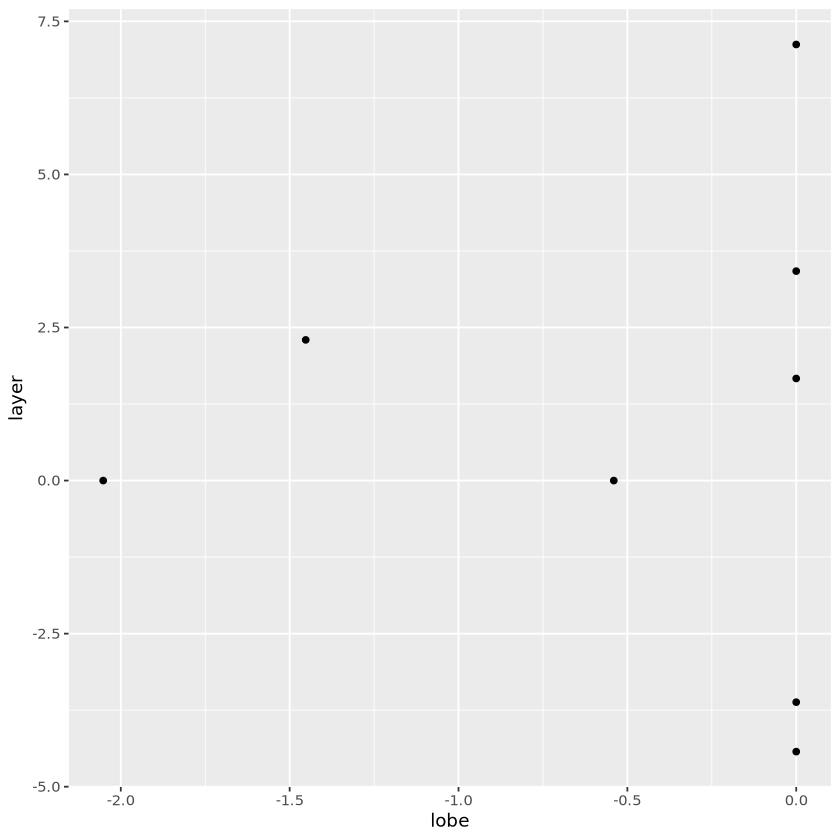

In [66]:
colnames(modelcoef2)[4] = "pvalue"
#modelcoef[modelcoef$pvalue < 0.05,] %>% group_by(group) %>% summarise(max(abs(Estimate)))
modelcoef.hub = modelcoef2[modelcoef2$pvalue < 0.05 & !modelcoef2$group %in% c("(Int","cell"),]
length(unique(modelcoef.hub$gene_id))
modelcoef.hub = modelcoef.hub %>% group_by(gene_id,group) %>% summarise(Estimate = mean(Estimate))
#modelcoef.hub = modelcoef[modelcoef$gene_id %in% modelcoef.hub$gene_id,]
library(reshape2)
library(ggplot2)
modelmx1 = dcast(modelcoef.hub,gene_id~group,value.var = "Estimate",fun.aggregate = sum)
ggplot(modelmx1,aes(x = lobe,y = layer)) + geom_point() 
modelmx1

In [108]:
head(modelcoef)

,Estimate,Std. Error,z value,pvalue,gene_id,areatr,groupt,group
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
(Intercept),-10.0655030,1.1452639,-8.7888070,1.511565e-18,APOE,(Intercept),(Int,(Int
meanrelative,21.0127851,1.5422955,13.6243578,2.869229e-42,APOE,meanrelative,mean,cell
lobecingulate,-0.7588753,0.6447097,-1.1770806,2.391633e-01,APOE,cingulate,lobe,lobe
lobeoccipital,-0.3244065,0.6577233,-0.4932264,6.218526e-01,APOE,occipital,lobe,lobe
lobeparietal,-0.6044447,0.6054899,-0.9982738,3.181466e-01,APOE,parietal,lobe,lobe
lobesomatosensory,-0.5515577,0.6625437,-0.8324850,4.051352e-01,APOE,somatosensory,lobe,lobe


[1] 166

`summarise()` has grouped output by 'gene_id'. You can override using the
`.groups` argument.


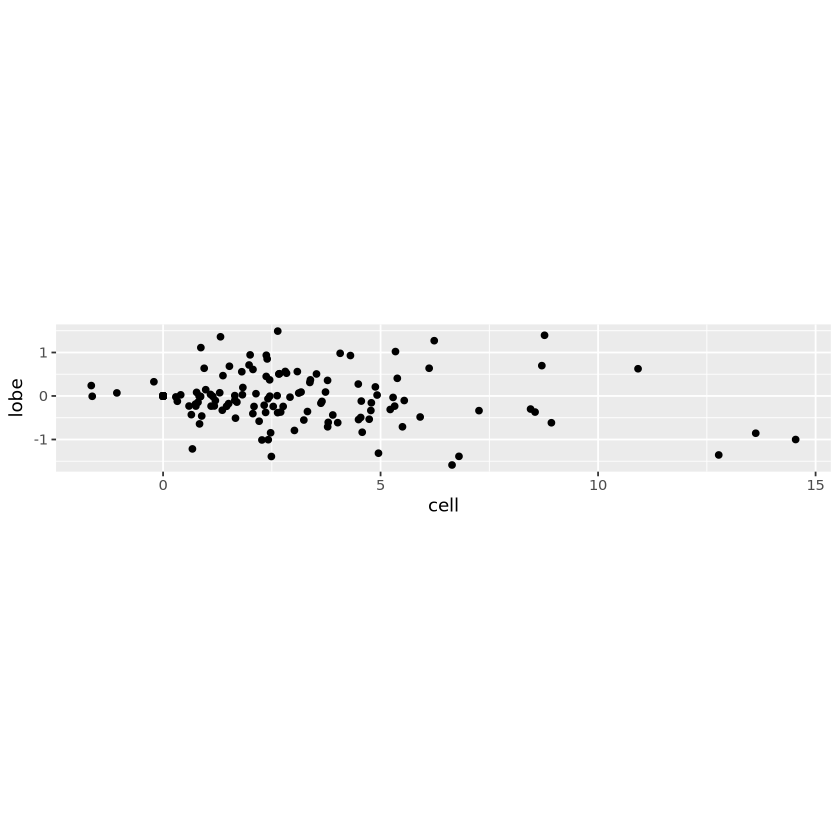

In [117]:
colnames(modelcoef)[4] = "pvalue"
#modelcoef[modelcoef$pvalue < 0.05,] %>% group_by(group) %>% summarise(max(abs(Estimate)))
hubgene = modelcoef[modelcoef$pvalue < 0.05,]$gene_id
modelcoef.hub = modelcoef[!modelcoef$group %in% c("(Int") & modelcoef$gene_id %in% hubgene,]
modelcoef.hub = modelcoef[!modelcoef$group %in% c("(Int"),]
length(unique(modelcoef.hub$gene_id))
#modelcoef.hub = modelcoef.hub %>% group_by(gene_id,group) %>% summarise(pvalue = -log10(min(pvalue[pvalue > 0])))
modelcoef.hub = modelcoef.hub %>% group_by(gene_id,group) %>% summarise(zscore = mean(`z value`))
modelmx1 = dcast(modelcoef.hub,gene_id~group,value.var = "zscore",fun.aggregate = sum)
ggplot(modelmx1[modelmx1$layer <10,],aes(x = cell,y = lobe)) + geom_point() + coord_fixed()

In [119]:
head(modelmx1[modelmx1$gene_id == "CIRBP",])

,gene_id,cell,layer,lobe
,<chr>,<dbl>,<dbl>,<dbl>
35,CIRBP,305.7212,36.88819,-4.065664


In [ ]:
library(lme4)
transt.lobei = transtf
# data 中包含以下列：
# gene_expression: 基因表达水平
# cell_type: 细胞类型（a, b, c）
# region: 空间区域（A, B, C）
# gene_id: 基因标识符

# 读取数据
# 模型拟合，包括区域效应
library(dplyr)
rf.lobe = NULL
rf.layer = NULL
rf.cell = NULL
for(i in unique(transt.lobei$transcript_id)){
    model_with_region = tryCatch(glmer(relative ~  meanrelative + (1|lobe) + (1|layer),
                            family = binomial(),
                            data = transt.lobei[transt.lobei$transcript_id == i,],
                            na.action = na.exclude), 
                   error = function(e) NA)
    if(!is.na(model_with_region)){
        random_effects <- ranef(model_with_region)
        randeffecti = random_effects$lobe
        randeffecti$transcript_id = i
        gi = transt.lobei[transt.lobei$transcript_id == i,]$gene_id[1]
        randeffecti$gene_id = gi
        randeffecti$areatr = rownames(randeffecti)
        rf.lobe = rbind(rf.lobe,randeffecti)

        randeffecti = random_effects$layer
        randeffecti$transcript_id = i
        randeffecti$gene_id = gi
        randeffecti$areatr = rownames(randeffecti)
        rf.layer = rbind(rf.layer,randeffecti)

        fixed_effects = fixef(model_with_region)
        rf.celli =  data.frame("Intercept" = fixed_effects[1],"transcript_id" = i,"gene_id" = gi)
        rf.cell = rbind(rf.cell,rf.celli)
    }    
    
   # print(summary(model_with_region))
}
#transt.lobei

In [101]:
# 提取固定效应的估计值
modelsm = summary(model_with_region)
modelsm$coefficients
names(modelsm)
# fixed_effects <- fixef(model_with_region)
# VarCorr(model_with_region)
# # 提取随机效应的估计值
# random_effects <- ranef(model_with_region)
# random_effects$lobe

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),-21.5211604,6.0284510,-3.5699320,0.0003570739
meanrelative,37.2044556,10.1160470,3.6777662,0.0002352855
layerl3,0.3442966,0.9137312,0.3768030,0.7063200131
layerl4,3.6994934,1.3131448,2.8172775,0.0048432658
layerl5,4.9218762,2.0737717,2.3733935,0.0176254749
layerl6,2.1487482,1.3407283,1.6026723,0.1090070140
lobecingulate,-0.8013962,1.2566643,-0.6377170,0.5236579008
lobeoccipital,-0.4309902,1.2723649,-0.3387316,0.7348119374
lobeparietal,0.8352708,1.2716173,0.6568571,0.5112728203
lobesomatosensory,-0.3054077,1.3394048,-0.2280175,0.8196326507


[1] "methTitle"    "objClass"     "devcomp"      "isLmer"       "useScale"    
 [6] "logLik"       "family"       "link"         "ngrps"        "coefficients"
[11] "sigma"        "vcov"         "varcor"       "AICtab"       "call"        
[16] "residuals"    "fitMsgs"      "optinfo"      "corrSet"

In [74]:
length(unique(rf.lobe[rf.lobe[,1] != 0,]$gene_id))
length(unique(rf.layer[rf.layer[,1] != 0,]$gene_id))
unique(rf.lobe[rf.lobe[,1] != 0,]$gene_id)
unique(rf.layer[rf.layer[,1] != 0,]$gene_id)

[1] 74

[1] 59

[1] "RPS10"          "FKBP2"          "GAP43"          "NDUFB9"        
 [5] "RPLP2"          "RPSA"           "RTN1"           "COPRS"         
 [9] "MEF2C"          "CA11"           "HAGH"           "SEZ6L2"        
[13] "SLC25A4"        "ACTR2"          "ANKS1B"         "APOO"          
[17] "APRT"           "ATP6V1C1"       "AUP1"           "BNIP3L"        
[21] "BRI3"           "BambuGene85043" "CABP1"          "CAMLG"         
[25] "CCNH"           "COPS5"          "CYSTM1"         "ENHO"          
[29] "EPHB6"          "FHL2"           "GRIA3"          "HNRNPH3"       
[33] "IDH3B"          "INTS1"          "KCNIP4"         "KLC1"          
[37] "LOC102114836"   "LOC102117014"   "LOC102141085"   "LOC107131073"  
[41] "MAP1LC3B"       "MAP6"           "MORF4L2"        "MPRIP"         
[45] "NDUFS7"         "NKIRAS1"        "NNAT"           "PDZD11"        
[49] "PICK1"          "POP5"           "PPFIA2"         "R3HDM2"        
[53] "RPL38"          "SEPT11"         "SLC25A3"        "SLC39A3"       
[57] "SNF8"           "TCEA2"          "TENM2"          "TM2D3"         
[61] "TMEM205"        "TPM3"           "TRAPPC1"        "TRIP12"        
[65] "TUBB2B"         "UBE2K"          "UBQLN1"         "VDAC3"         
[69] "VTI1B"          "ZMYND8"         "ZNF428"         "ARPP21"        
[73] "DBNDD2"         "SLC44A1"

[1] "ARPP19"          "ATP2B1"          "GAP43"           "LOC102122855"   
 [5] "NDUFB9"          "RPLP2"           "SNRPN"           "DDRGK1"         
 [9] "THRA"            "AKAP9"           "ASRGL1"          "BAG1"           
[13] "BambuGene103646" "BambuGene85043"  "CABP1"           "CAPNS1"         
[17] "CCDC149"         "CD200"           "CDH2"            "ENHO"           
[21] "EPHB6"           "FKBP2"           "GOLGB1"          "GRIA3"          
[25] "HAGH"            "HMOX2"           "KALRN"           "KCNIP4"         
[29] "KLC1"            "LOC102114836"    "LOC102117014"    "LOC107126439"   
[33] "MAP1LC3B"        "MAP6"            "MPRIP"           "NDUFS7"         
[37] "NNAT"            "NUDC"            "PDZD11"          "PFDN1"          
[41] "PTPMT1"          "RANBP1"          "RNF41"           "RUNDC3A"        
[45] "SLC25A4"         "SLC39A3"         "SMIM19"          "SNF8"           
[49] "SRSF5"           "SUMO1"           "TENM2"           "TM2D3"          
[53] "TRAPPC1"         "USP9X"           "VTI1B"           "YWHAZ"          
[57] "ZMYND8"          "ARPP21"          "MAL"

In [2]:
library(Seurat)
data_dir <- '/cluster/home/liuhengxin/P_Brain_tumer_fullscope/refdata/T755/'
list.files(data_dir) # Should show barcodes.tsv, genes.tsv, and matrix.mtx
expression_matrix <- Read10X(data.dir = data_dir)
srt = CreateSeuratObject(counts = expression_matrix)
srt

Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built with package ‘Matrix’ 1.6.5 but the current
version is 1.7.0; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t




[1] "barcodes.tsv.gz"      "features.tsv.gz"      "matrix.mtx.gz"       
[4] "tissue_positions.tsv"

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
45756 features across 46484 samples within 1 assay 
Active assay: RNA (45756 features, 0 variable features)
 1 layer present: counts

In [4]:
sum(expression_matrix["IDH1",])

[1] 816

In [5]:
genect = rowSums(expression_matrix)
head(genect)

AC123912.4  SGMS1-AS1      CENPO     SEPT12       TSIX AL663058.2 
        77        393        242         85         25         46

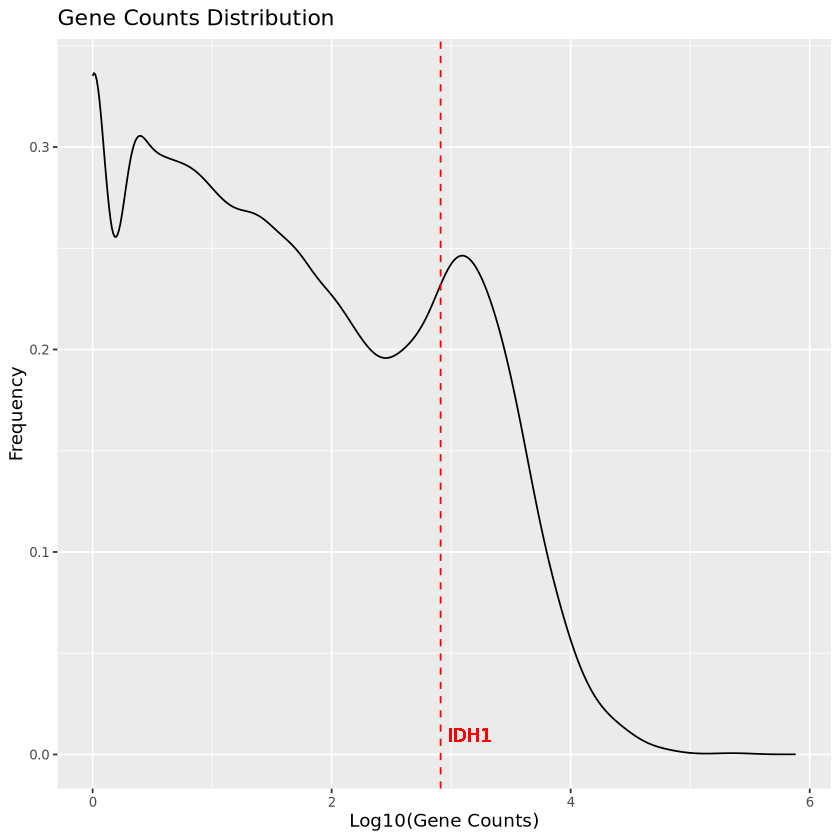

In [6]:
library(ggplot2)
# 创建数据框
datadf <- data.frame(value = genect, name = names(genect))
# 绘制直方图
p1 <- ggplot(datadf, aes(x = log10(value+1))) +
  geom_density() +
  labs(title = "Gene Counts Distribution", x = "Value", y = "Frequency")
# 计算特定变量的数值位置
value_to_label <- log10(datadf$value[datadf$name == "IDH1"])

# 添加垂直线和文本标注
p1 = p1 + geom_vline(xintercept = value_to_label, linetype = "dashed", color = "red") +
  geom_text(label = "IDH1", x = value_to_label,y = 0.0, hjust = -0.15, vjust = -1, color = "red") + xlab("Log10(Gene Counts)") +
theme(axis.text = element_text(size = 8))
p1

Warning message in geom_text(aes(label = "IDH1"), x = value_to_label, y = 0.5, vjust = -1, :
“All aesthetics have length 1, but the data has 45756 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message:
“Removed 4622 rows containing non-finite outside the scale range
(`stat_ecdf()`).”


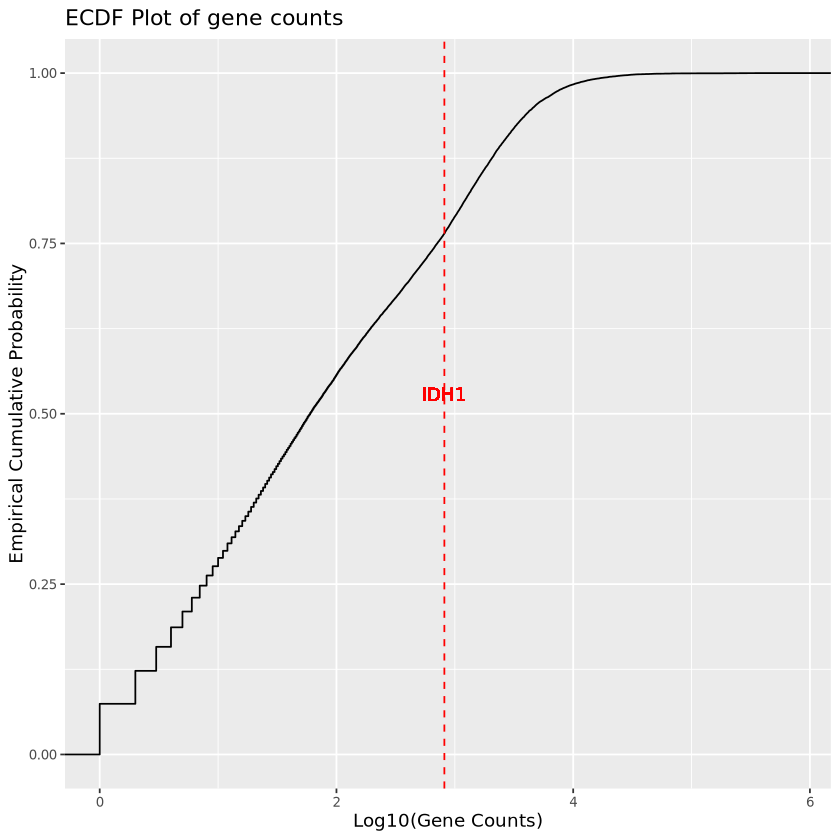

In [50]:
value_to_label <- log10(datadf$value[datadf$name == "IDH1"])  # 你想要标注的特定值
p2 = ggplot(datadf, aes(x = log10(value))) + 
  stat_ecdf(geom = "step") +
  geom_vline(xintercept = value_to_label, linetype = "dashed", color = "red") +
  geom_text(aes(label = "IDH1"), x = value_to_label, y = 0.5, vjust = -1, color = "red") +
  ggtitle("ECDF Plot of gene counts") +
  xlab("Log10(Gene Counts)") +
  ylab("Empirical Cumulative Probability") +
theme(axis.text = element_text(size = 8))
p2

In [7]:
datadf = datadf[datadf$value > 10,]
datadf = datadf[order(-datadf$value),]
datadf$rank = 1:nrow(datadf)
head(datadf,n = 20)

,value,name,rank
,<dbl>,<chr>,<int>
MT-RNR2,763451,MT-RNR2,1
MT-ATP6,341484,MT-ATP6,2
MT-ND4,296171,MT-ND4,3
MT-CO3,284164,MT-CO3,4
MBP,264148,MBP,5
PLP1,251890,PLP1,6
MT-RNR1,239696,MT-RNR1,7
MT-CO2,224909,MT-CO2,8
MT-CYB,190360,MT-CYB,9


In [11]:
sum(datadf[substr(datadf$name,1,3) == "MT-",]$value)/sum(datadf$value)

[1] 0.07151048

[1] 19584

Warning message in geom_text(aes(label = "IDH1"), x = value_to_label, y = 0.5, vjust = -1, :
“All aesthetics have length 1, but the data has 45756 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message:
“Removed 4622 rows containing non-finite outside the scale range
(`stat_ecdf()`).”


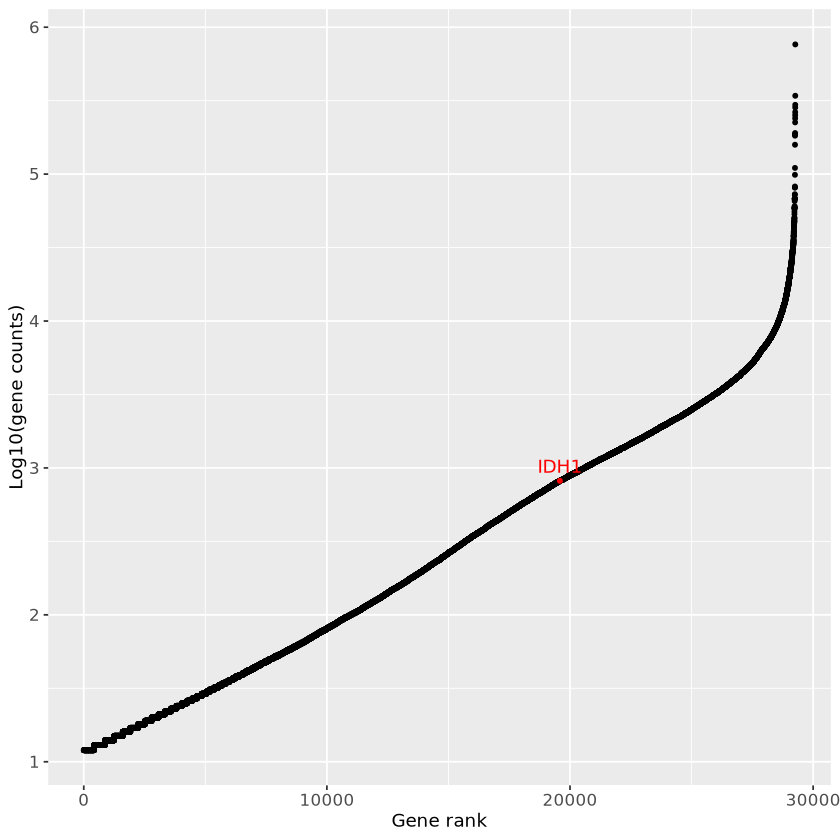

In [54]:
datadf = datadf[datadf$value > 10,]
datadf = datadf[order(datadf$value),]
datadf$rank = 1:nrow(datadf)
which(datadf$name == "IDH1")
value_to_label <- log10(datadf$value[datadf$name == "IDH1"])  # 你想要标注的特定值
datadf$sig = "N"
datadf[datadf$name == "IDH1",]$sig = 'Y'
datadf = datadf[order(datadf$sig),]
p3 = ggplot(datadf, aes(x = rank, y = log10(value+1),color = sig)) + 
  geom_point(size = 1) +
  geom_text(data = datadf[datadf$name == "IDH1",], aes(label = "IDH1",x = rank, y = log10(value)), nudge_x = 0.1, nudge_y = 0.1) +
  scale_color_manual(values = c("black","red")) +
  #geom_vline(xintercept = value_to_label, linetype = "dashed", color = "red") +
  xlab("Gene rank") +
  ylab("Log10(gene counts)") +
  theme(axis.text = element_text(size = 10),legend.position = "none")
p3
ggsave(p1+p2+p3,file = "/cluster/home/liuhengxin/P_Brain_tumer_fullscope/analysis/figures/IDH1_generank_stat_T757.pdf",width = 10,height = 4)

In [52]:
data.frame(800/45000000, 100/7000000)

X800.4.5e.07,X100.7e.06
<dbl>,<dbl>
1.777778e-05,1.428571e-05


Warning message in geom_text(aes(label = "IDH1"), x = value_to_label, y = 0.5, vjust = -1, :
“All aesthetics have length 1, but the data has 45756 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message:
“Removed 4622 rows containing non-finite outside the scale range
(`stat_ecdf()`).”
Don't know how to automatically pick scale for object of type <function>.
Defaulting to continuous.
ERROR while rich displaying an object: Error in `geom_point()`:
! Problem while computing aesthetics.
ℹ Error occurred in the 1st layer.
Caused by error in `compute_aesthetics()`:
! Aesthetics are not valid data columns.
✖ The following aesthetics are invalid:
✖ `x = rank`
ℹ Did you mistype the name of a data column or forget to add `after_stat()`?

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop(